# Predicting Singapore Maturity Movie Ratings (PG,PG13,NC16,M18,R21) from movie synopsis

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
df = pd.read_csv("https://raw.githubusercontent.com/garyongguanjie/moviecsv/master/movie_cleaned.csv")#cleaning of data is taken out as it takes too long
df.head()
df = df.sample(frac=1).reset_index(drop=True)
RATING_LIST = ["PG","PG13","NC16","M18","R21"]

In [0]:
g = df.groupby('rating')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
df = g.droplevel(0)
df = df.sample(frac=1).reset_index(drop=True)

In [0]:
df.head()

,movie_title,synopsis,rating,synopsis_clean
0,The Wackness,For psychoanalyst Dr. Jeffrey Squires (Ben Kin...,R21,psychoanalyst dr jeffrey squire ben kingsley s...
1,Compliance,"Sandra, a manager of a fast-food restaurant in...",NC16,sandra manager fast food restaurant chickwich ...
2,Hellraiser,"Somewhere in North Africa, Frank Cotton (Sean ...",R21,somewhere north africa frank cotton sean chapm...
3,Misconduct,Denning is a rich CEO of a giant pharma compan...,NC16,denning rich ceo giant pharma company emily wo...
4,The Year of Living Dangerously,"A rookie Australian journalist, covering the I...",PG,rookie australian journalist covering indonesi...


## Data Visualisation and Statistics

In [0]:
def top_k_n_grams(k,n):
  """
  get k most frequent words/ngram words
  """
  cv = CountVectorizer(ngram_range=(n,n))
  features = cv.fit_transform(df['synopsis_clean'])
  sum1 = np.ravel(np.sum(features,axis=0))
  indices = np.argsort(sum1)[::-1][:k]
  feature_names = np.array(cv.get_feature_names())[indices]
  plt.bar(range(0,k),sum1[indices],tick_label=feature_names)
  if n==1:
    plt.title("Most common words")
  else:
    plt.title("Most common {}-grams".format(n))
  plt.xticks(rotation='vertical')
  plt.show()

Number of samples 2040 

Median number of words: 504.0 

rating
M18     408
NC16    408
PG      408
PG13    408
R21     408
dtype: int64 



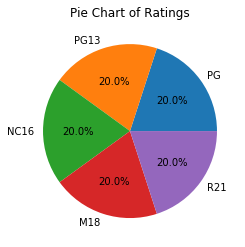

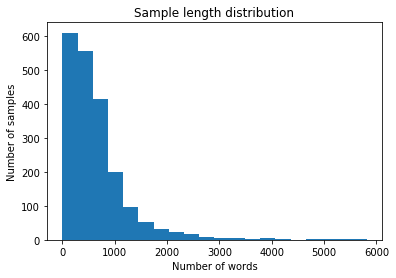

In [0]:
print("Number of samples",df.shape[0],"\n")
print("Median number of words: {}".format(np.median(df['synopsis_clean'].str.split().apply(len))),"\n")
group = df.groupby('rating')
#Distribution of Ratings
# plt.hist(df['rating'],bins='auto')
# plt.title('Distribution of Ratings')
# plt.xlabel('rating')
# plt.ylabel('Number of samples')
sizeList = []
for rating in RATING_LIST:
  n = group.get_group(rating).shape[0]
  sizeList.append(n)
print(group.size(),"\n")
plt.pie(sizeList,labels=RATING_LIST,autopct='%1.1f%%')
plt.title('Pie Chart of Ratings')
plt.show()
#Sample Length Distribution

plt.hist(df['synopsis_clean'].str.split().apply(len),bins =20);
plt.xlabel('Number of words')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

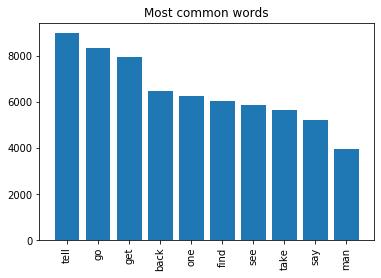

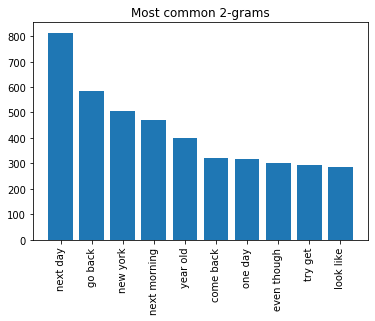

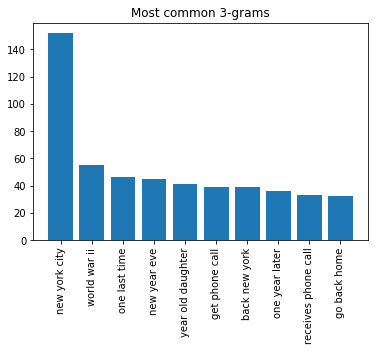

In [0]:
## Most frequent words
for i in range(1,4):
  top_k_n_grams(10,i)

In [0]:
df.head()
def ordinalise(rating):
  ordinal_dict = {'PG':0,'PG13':1,'NC16':2,'M18':3,'R21':4}
  return ordinal_dict[rating]
df['ordinal_rating'] =  df['rating'].apply(lambda x:ordinalise(x))

# Naive Models

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df['synopsis_clean'], df['ordinal_rating'], test_size=0.1, random_state=None)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
def show_confusion_matrix(conf_mat,classifier):
  import seaborn as sn
  labels = RATING_LIST
  df_cm = pd.DataFrame(conf_mat, index = [i for i in labels ],
                  columns = [i for i in labels])
  plt.figure(figsize = (10,7))
  s= sn.heatmap(df_cm, annot=True,fmt='d',cmap='Blues')
  s.set(xlabel="predicted",ylabel="actual")
  bottom, top = s.get_ylim()
  s.set_ylim(bottom + 0.5, top - 0.5)
  plt.show()

In [0]:
def evaluate_model(model,k_top_words=10):
  """
  ktop words only works for models with weights that directly affect the classification
  """
  prediction = model.predict(x_test)
  print(classification_report(y_test,prediction))
  # vect,clf = list(model.named_steps.keys())
  # coef = model.named_steps[clf].coef_
  # vect = model.named_steps[vect].get_feature_names()
  # x = np.argsort(coef[0])[-k_top_words:][::-1]
  # matureWords = []
  # for i in x:
  #   matureWords.append(vect[i])
  # print("words with highest weights")
  # print("Note since this is multiclass classification weights do not lean to preference for any particular class")
  # print(matureWords)
  cm = confusion_matrix(y_test,prediction)
  show_confusion_matrix(cm,text_clf4)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
text_clf4 = Pipeline([
                      ('vect4',TfidfVectorizer(use_idf=False,ngram_range=(1,2),min_df=5,sublinear_tf=True)),
                      ('clf4',LogisticRegression(C=10,solver='liblinear',multi_class='auto'))]
                          
)
text_clf4.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('vect4',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=5, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=False,
                                 vocabulary=None)),
                ('clf4',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling

In [0]:
def predict_values():
  """
  To see probabilities of prediction
  """
  return text_clf4.predict_proba(x_test)
# print(predict_values())
# print(x_test[0])
# print(y_test[0])

In [0]:
def lax_evaluate(a,b):
    return float(np.average(np.abs(b-a)<2))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56        54
           1       0.25      0.23      0.24        39
           2       0.29      0.48      0.36        29
           3       0.36      0.31      0.33        42
           4       0.42      0.40      0.41        40

    accuracy                           0.39       204
   macro avg       0.39      0.39      0.38       204
weighted avg       0.41      0.39      0.39       204



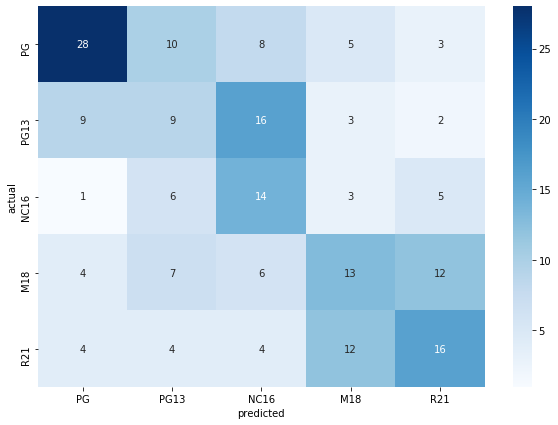

0.7549019607843137


In [0]:

evaluate_model(text_clf4)
prediction = text_clf4.predict(x_test)
print(lax_evaluate(prediction,y_test))

# Naive Model because 
Model does not take into account ordinality of data!

For example PG is much closer to PG13 than to R21!

Model does not take into account sequence of more than 2 words since ngram is only up till 2.

Model does not use any pre-existing word vectors or sentence vectors to analyse similar words

# OrdClass
Ordinal Classifier

Maturity ratings are not completely nominal. 
For example the order sexual scenes and physcical violence: PG<PG13<NC16<M18<R21

Using nominal classifier would not allow us to capture ordinal data.

However using a regressive model i.e. manually assigning each rating with a number in increasing order would result in a bad fit of data as all the y-values of a certain rating would be the same.

Implemented method described in this research paper
https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf

1. Assign ordinality PG = 0,PG13=1,NC16=2,M18=3,R21=4
2. Find binary classifiers for P(Y>PG|X),P(Y>PG13|x),P(Y>NC16|X),P(Y>M18|X)
3. Calculate probability class distribution for each example by taking

  P(Y=PG|X) = 1 - P(Y>PG|X)

  P(Y = R21|X) = P(Y>M18|X)
    
  For all other classes:
  P(Y=NC16|X) = P(Y>PG13|X) - P(Y>NC16|X)...
4. The maximum probability is then the predicted class

Results:

Slightly higher accuracy

Lower severe incorrect predictions i.e. R21 predicted as PG and vice versa


In [0]:
from sklearn.base import BaseEstimator
class OrdClass(BaseEstimator):
  """
  Helper class that solves ordinal classification (classes that have an order to them eg cold,warm,hot)
  """
  def __init__(self,classifier=None,func_fit=None,clf_args=None):
    """
    y needs to be a number that start from 0 and increments by 1
    classifier object needs to be able to return a probability
    """
    self.classifier = classifier
    self.clfs = []
    self.clf_args = clf_args
    self.final_prob = None
  
  def fit(self,X,y,**fit):
    self.X = X
    self.y = y
    import copy
    no_of_classifiers = np.max(self.y) #since y starts from 0
    self.classes_ = list(range(no_of_classifiers+1))
    if isinstance(self.clf_args,list):
      #for pipelines
      c = self.classifier(self.clf_args)
    elif isinstance(self.clf_args,dict):
      #for normal estimators
       c = self.classifier(**self.clf_args)
    for i in range(no_of_classifiers):
      # make a copy of y because we want to change the values of y
      copy_y = np.copy(self.y)
      # make a binary classification here
      copy_y[copy_y<=i] = 0
      copy_y[copy_y>i] = 1
      classifier = copy.deepcopy(c)
      classifier.fit(self.X,copy_y,**fit)
      self.clfs.append(classifier)
    return self
  def predict_proba(self,test):
    prob_list = []
    final_prob = []
    length = len(self.clfs)
    for clf in self.clfs:
      prob_list.append(clf.predict_proba(test)[:,1])
    for i in range(length+1):
      if i == 0:
        final_prob.append(1-prob_list[i])
      elif i == length:
        final_prob.append(prob_list[i-1])
      else:
        final_prob.append(prob_list[i-1]-prob_list[i])
    answer = np.array(final_prob).transpose()
    self.final_prob= answer
    return answer
  def predict(self,test):
    self.predict_proba(test)
    return np.argmax(self.final_prob,axis=1)
  def score(self,X,y,sample_weight=None):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df['synopsis_clean'], df['ordinal_rating'], test_size=0.1, random_state=1)

In [0]:
classifier = Pipeline
func_fit = Pipeline.fit
clf_args = [
                      ('vect4',TfidfVectorizer(use_idf=False,ngram_range=(1,2),min_df=5,sublinear_tf=True)),
                      ('clf4',LogisticRegression(C=10,solver='liblinear',multi_class='auto'))]
o = OrdClass(classifier,func_fit,clf_args)
o.fit(x_train,y_train)
o.classes_ = RATING_LIST

In [0]:
p = o.predict(x_test)

In [0]:
#train_2 =o.predict_proba(x_train)
# from sklearn.linear_model import Perceptron
# clf = Perceptron()
# clf.fit(train_2,y_train)
# p = clf.predict(o.predict_proba(x_test))

In [0]:
print(classification_report(y_test,p))

              precision    recall  f1-score   support

           0       0.52      0.32      0.40        34
           1       0.26      0.36      0.30        33
           2       0.28      0.40      0.33        43
           3       0.40      0.38      0.39        50
           4       0.43      0.27      0.33        44

    accuracy                           0.35       204
   macro avg       0.38      0.35      0.35       204
weighted avg       0.38      0.35      0.35       204



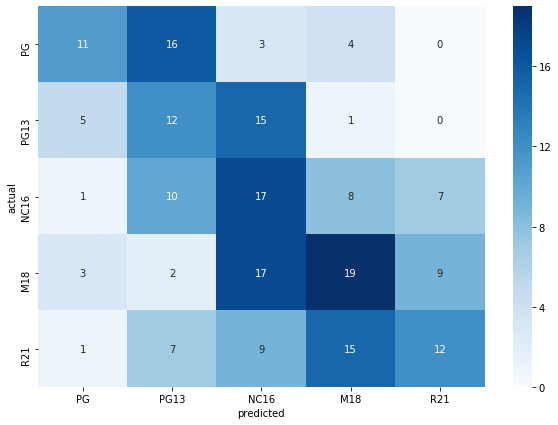

In [0]:
cm = confusion_matrix(y_test,p)
show_confusion_matrix(cm,o)

In [0]:
from sklearn.metrics import make_scorer
scorer = make_scorer(lax_evaluate)
lax_evaluate(p,y_test)

0.8137254901960784

In [0]:
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(text_clf4,df['synopsis_clean'],df['ordinal_rating'],cv=10,scoring='neg_mean_squared_error')))

-2.2308414634146336


In [0]:
print(np.mean(cross_val_score(o,df['synopsis_clean'],df['ordinal_rating'],cv=10,scoring='neg_mean_squared_error')))

-1.8284313725490198


In [0]:
for i in range(50,1200,50):
  print(i)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
